### **Import Dataset & Library**

In [ ]:
from google.colab import files
files.upload()  # Unggah file kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"siwiyulindaa","key":"ad78ca7a19317ebd2f03ea7fd99677ba"}'}

In [ ]:
!mkdir -p ~/.kaggle  # Membuat direktori .kaggle jika belum ada
!mv kaggle.json ~/.kaggle/  # Memindahkan file kaggle.json ke .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Mengatur izin file agar lebih aman

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Unduh dataset ke direktori pilihan, misalnya /content/dataset
!kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset
License(s): CC-BY-SA-4.0
 94% 256M/273M [00:02<00:00, 106MB/s]
100% 273M/273M [00:02<00:00, 121MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/dataset/augmented-skin-conditions-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt

In [ ]:
# 3. Load and Preprocess Dataset
dataset_path = '/content/dataset/Skin_Conditions'  # Update this if dataset structure changes

In [ ]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 2394 files belonging to 6 classes.


In [ ]:
# Class names
class_names = dataset.class_names
print("Detected Classes:", class_names)

Detected Classes: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


### **Preprosessing**

In [ ]:
# Split dataset
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)

    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    test_dataset = dataset.skip(val_end)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Augmentasi dataset
def augment_data(dataset):
    def augment(image, label):
        image = data_augmentation(image)
        return image, label

    return dataset.map(augment)

train_dataset = augment_data(train_dataset)

### **Model EfficientNetB6**

In [ ]:
# 4. Load EfficientNetB6 pre-trained
base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Tambahkan layer klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 56)   │          1,512 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 56)   │            224 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 56)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 56)   │            504 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 56)   │            224 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 56)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 56)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 56)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 14)       │            798 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 41,551,765 (158.51 MB)

 Trainable params: 591,622 (2.26 MB)

 Non-trainable params: 40,960,143 (156.25 MB)

### **Train Model**

In [ ]:
# 5. Train the Model
# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Simpan model terbaik
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.8436 - loss: 0.5462 - val_accuracy: 0.8438 - val_loss: 0.4405
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 690ms/step - accuracy: 0.8378 - loss: 0.5275 - val_accuracy: 0.8661 - val_loss: 0.4364
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 629ms/step - accuracy: 0.8623 - loss: 0.4843 - val_accuracy: 0.8795 - val_loss: 0.4017
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 614ms/step - accuracy: 0.8622 - loss: 0.4794 - val_accuracy: 0.8884 - val_loss: 0.4225
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 592ms/step - accuracy: 0.8492 - loss: 0.5009 - val_accuracy: 0.8393 - val_loss: 0.4734
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.8418 - loss: 0.5001 - val_accuracy: 0.8929 - val_loss: 0.3751
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 607ms/step - accuracy: 0.8493 - loss: 0.4778 - val_accuracy: 0.8705 - val_loss: 0.4134
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 594ms/step - accuracy: 0.8498 - loss: 0.4819 - val_accu

In [ ]:
# 6. Evaluate the Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8282 - loss: 0.4811
Test Accuracy: 0.8440


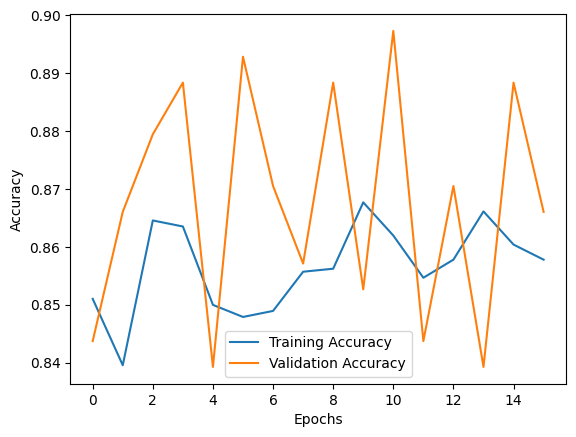

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


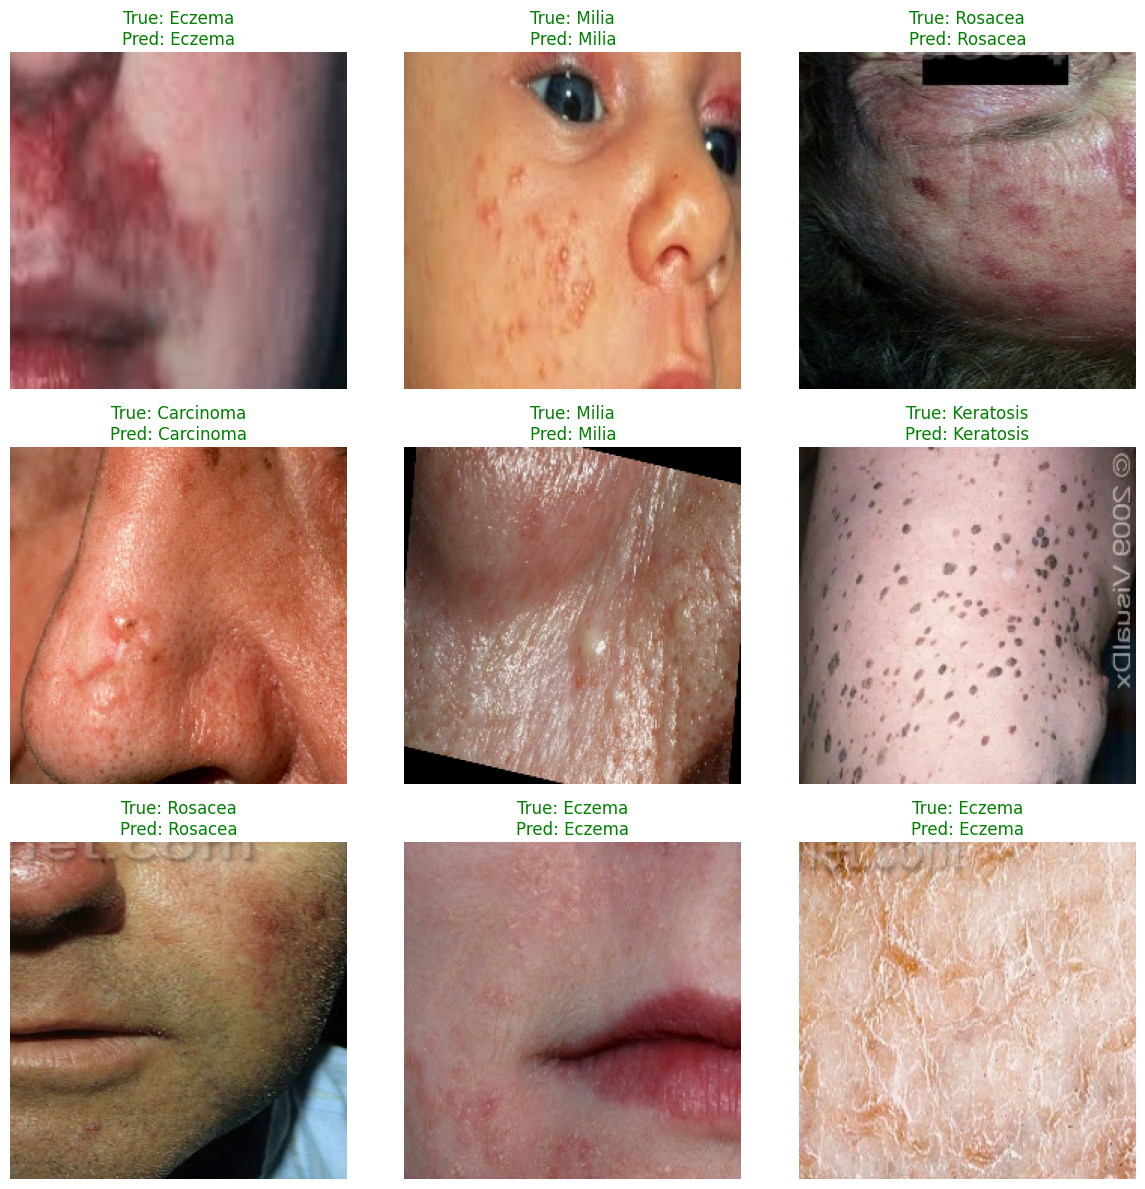

In [ ]:
# Plot akurasi training dan validasi
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history)

# Visualisasi hasil prediksi pada test dataset
def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = tf.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')

            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)